In [1]:
import glob
import re
import os
import numpy as np
from torch.utils.data import Dataset
import torch
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import PIL
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim



from src.datasets import sigcomp2009, mnist, cedar, pds_sigcomp2009, pds_mnist
from src.pair_dataset import *
from src.visualization import *
from src.tools import *
from src.models import *
from src.train import *

Sigcomp len(ds_train):940 len(ds_valid):60


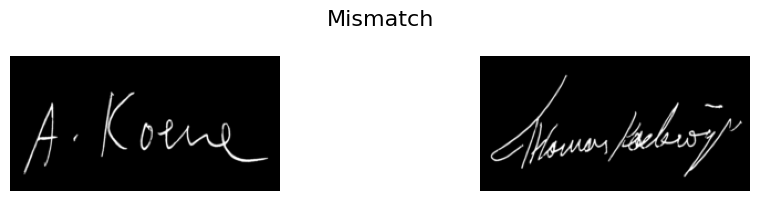

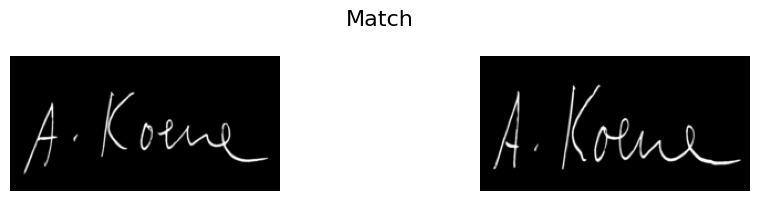

In [2]:
ds_train, ds_valid, pds_train, pds_valid = pds_sigcomp2009()

In [3]:
dl_train = torch.utils.data.DataLoader(pds_train, batch_size=64, shuffle=True, num_workers=0)
dl_valid = torch.utils.data.DataLoader(pds_valid, batch_size=32, shuffle=False, num_workers=0)

In [9]:
def single_batch(dl,device):
    b = next(iter(dl))
    b = [x.to(device) for x in b]
    print(f'Getting single batch. Shapes: {shapes(b)}')
    return b

b=single_batch(dl_valid,device)

Getting single batch. Shapes: [torch.Size([32, 3, 122, 244]), torch.Size([32, 3, 122, 244]), torch.Size([32]), torch.Size([32])]


In [15]:
def get_encoder_out_dim(encoder, x):
    with torch.no_grad():
        return encoder(x).shape[-1]

conv_encoder = Encoder_Resnet18().to(device)
get_encoder_out_dim(conv_encoder,b[0])

1024

In [44]:
encoder = torch.nn.Sequential(
    conv_encoder,
    mlp(1024,256)
).to(device)
get_encoder_out_dim(encoder,b[0])

256

In [45]:
class SiamessContrastive(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.criterion = torch.nn.CosineEmbeddingLoss(margin=0.5)

    def forward(self, x1,x2, y1, y2):
        f1 = self.encoder(x1)
        f2 = self.encoder(x2)
        labels = torch.where((y1==y2),1,-1)
        loss = self.criterion(f1,f2,labels)
        return f1, f2, labels, loss

model = SiamessContrastive(encoder).to(device)
with torch.no_grad():
    r=model(*b)
    print(shapes(r))
    print(r[-1])

[torch.Size([32, 256]), torch.Size([32, 256]), torch.Size([32]), torch.Size([])]
tensor(0.3810, device='mps:0')


In [46]:
opt = optim.AdamW(model.parameters(), lr=lr, eps=adam_eps)

In [47]:
training_epoch(model, opt, dl_train, device)

Training epoch [1/1]: 100%|█████████████████████| 30/30 [00:40<00:00,  1.35s/it]

Epoch [1/1], Training loss: 0.1653


In [60]:
for n_epoch in range(5):
    training_epoch(model, opt, dl_train, device, n_epoch, 5)

Training epoch [1/5]: 100%|█████████████████████| 30/30 [00:40<00:00,  1.36s/it]


Epoch [1/5], Training loss: 0.0372


Training epoch [2/5]: 100%|█████████████████████| 30/30 [00:40<00:00,  1.35s/it]


Epoch [2/5], Training loss: 0.0341


Training epoch [3/5]: 100%|█████████████████████| 30/30 [00:40<00:00,  1.35s/it]


Epoch [3/5], Training loss: 0.0366


Training epoch [4/5]: 100%|█████████████████████| 30/30 [00:42<00:00,  1.42s/it]


Epoch [4/5], Training loss: 0.0350


Training epoch [5/5]: 100%|█████████████████████| 30/30 [00:50<00:00,  1.68s/it]

Epoch [5/5], Training loss: 0.0398


In [61]:


all_f1 = []
all_f2 = []
all_y1 = []
all_y2 = []
model.eval()
with torch.no_grad():
    for x1, x2, y1, y2 in tqdm.tqdm(dl_valid, desc=f'Valid epoch [{n_epoch + 1}/{1}]'):
        x1, x2, y1, y2 = x1.to(device), x2.to(device), y1.to(device), y2.to(device)
        B = x1.size(0)
        f1,f2 = model(x1, x2, y1, y2)[:2]
        all_f1.append(f1)
        all_f2.append(f2)
        all_y1.append(y1)
        all_y2.append(y2)
all_f1 = torch.concat(all_f1)
all_f2 = torch.concat(all_f2)
all_y1 = torch.concat(all_y1)
all_y2 = torch.concat(all_y2)


Valid epoch [5/1]: 100%|██████████████████████████| 4/4 [00:04<00:00,  1.24s/it]


In [62]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
d=cos(all_f1,all_f2)
d

tensor([ 8.7223e-01,  9.6382e-01,  3.3242e-01,  7.9107e-01,  3.3242e-01,
         9.9950e-01,  2.6250e-01,  9.9510e-01,  4.1232e-01,  9.7510e-01,
         4.8988e-01,  1.0000e+00, -2.0128e-01,  9.3988e-01,  2.1917e-01,
         9.9029e-01, -4.9800e-02,  9.4461e-01,  6.3119e-02,  9.5669e-01,
         8.0488e-01, -5.8120e-02,  9.2340e-01,  6.8066e-01,  6.2148e-01,
         9.7209e-01, -6.2240e-04,  9.8723e-01, -1.8920e-01,  9.0144e-01,
         9.2155e-01,  9.6064e-01,  8.6661e-01,  1.0000e+00,  2.9004e-01,
         1.0000e+00,  7.2271e-01,  1.0000e+00,  4.2192e-01,  9.7097e-01,
        -3.7095e-01,  1.0000e+00,  3.3273e-01,  1.0000e+00,  9.8169e-01,
         1.0000e+00,  6.8432e-01,  9.2412e-01, -1.1721e-01,  9.7900e-01,
         7.8452e-01,  9.5065e-01,  3.2172e-01,  9.5129e-01,  9.4424e-01,
         9.9552e-01, -1.2947e-01,  9.3658e-01,  7.5167e-01,  1.0000e+00,
         5.5637e-01,  7.0193e-01,  8.1192e-01,  9.5925e-01, -2.1870e-02,
         1.0000e+00,  1.0464e-01,  1.0000e+00,  4.2

In [63]:
predictions = d>=0.5

In [64]:
labels = (all_y1==all_y2)
labels.shape

torch.Size([120])

In [65]:
(labels==predictions).float().mean()

tensor(0.8000, device='mps:0')